In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Vortex panel method

The previous notebook introduced the concept of vortex sheets. We will now extend this concept to solve to the flow around general objects by setting up and solving a system of linear equations.

## General vortex sheets

A curved vortex sheet with a variable strength can describe the flow around any immersed object. This is achieved by having the sheet act as an infinitely thin version of the boundary layer to enforce the no-slip boundary condition. 

---
![Vortex sheets as boundary layers](resources/impulse.png)

---

In other words we use the sheets to force the tangential velocity $u_s$ to zero at every point $s$ on the body surface $\cal S$

$$u_s = \vec u \cdot \hat s = 0 \quad s \in \cal S.$$

From the previous notebook, we know the velocity at any point is determined by an integral over the whole vortex sheet. Therefore, the tangential velocity condition is

$$ u_s = \left[\vec U_\infty+\frac{\partial}{\partial \vec x}\oint_{\cal S} \frac{\gamma(s')}{2\pi}\theta(s,s')\ ds'\right] \cdot\hat s = 0 $$

where $\vec U_\infty$ is the background velocity that has been added by superposition. 

**If we can use this equation to determine the strength distribution $\gamma(s)$ along the sheet then we will have solved for the potential flow around the body!**

## Discrete vortex panels

For general body surface shapes the velocity is a highly nonlinear function of $\gamma(s)$, rendering analytic solution unlikely. We could attempt some complex analytic expansions, but why would we want to do that?

##### Numerical fundamental: Discritization
##### Replace continuous functions with linear approximations

We already know that the velocity depends **linearly** on $\gamma$ for a vortex panel. This makes it easy to solve for $\gamma$ as a function of $u_s$. And we can add any number of panels together using superposition.

Therefore, if we break up the continuous sheet into a series of vortex panels, we can approximate the tangential velocity condition above, and use it to solve for $\gamma$. 

---
![Vortex panelized](resources/graphics2.png)

---

This is the essence of the *vortex panel method*.

## Linear velocity function

First, lets write the velocity induced by a single panel in a way that makes the linearity explicit:

$$ \vec u(x,y)=\gamma\ \vec f(x,y \ |\ x_0,y_0,x_1,y_1)$$

where $\vec f$ is a function that depends on the panel geometry. 

In fact, we've already written all the code we need to evaluate this function in VortexPanel module, we just need to import it again. 

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline
from VortexPanel import Panel

##### Quiz 1

Which `Panel` function can we use to evaluate `f`?

1. `Panel.plot()`
1. `Panel.velocity(gamma=0)`
1. `Panel.velocity(gamma=1)`

Hint: Use `help` again to see the function arguments if you need to.

## Array of panels

The next step is to extend this to more than one panel and to add the background flow.

To help make this more concrete, lets consider a polynomial-shape body. I found this beautiful little equation to define [regular polynomials](http://math.stackexchange.com/questions/41940/is-there-an-equation-to-describe-regular-polygons/41954#41954).

In [3]:
def polynomial(theta,N_sides):
    a = theta % (2.*numpy.pi/N_sides)-numpy.pi/N_sides
    r = numpy.cos(numpy.pi/N_sides)/numpy.cos(a)
    return [r*numpy.cos(theta),r*numpy.sin(theta)]

where `N_sides` is the number of sides in the polynomial, and `theta`=$\theta$ is the polar angle around the origin.

Lets define a function to make a polynomial array of panels.

In [4]:
def make_poly(N_panels,N_sides):
    # define the end-points
    theta = numpy.linspace(0, -2*numpy.pi, N_panels+1)   # equal radial spacing
    x_ends,y_ends = polynomial( theta, N_sides)          # get the coordinates

    # define the panels
    panels = numpy.empty(N_panels, dtype=object)         # empty array of panels
    for i in range(N_panels):                            # fill the array
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

    return panels

Lets plot it to check if we did it right...

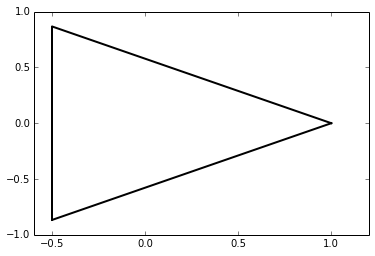

In [5]:
N_panels = 3
triangle = make_poly(N_panels,N_sides=3)
for p in triangle: p.plot()

Looks good. Note the code 

`for p in triangle:` 

loops through all the panels in the array. Very handy and clean.

---
So, what is the velocity induced by these panels? 

Using superposition, the total velocity at any point $x,y$ is simply

$$ \vec u(x,y) = \vec U_\infty+\sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y) $$

where we use the index  $j$ to label each of the $N$ panels.

This can be coded as:

In [6]:
def flow_velocity(panels,x,y,alpha=0):
    # get the uniform velocity ( make it the same size & shape as x )
    u = numpy.cos(alpha)*numpy.ones_like(x)
    v = numpy.sin(alpha)*numpy.ones_like(x)
    
    # add the velocity contribution from each panel
    for p in panels:
        u0,v0 = p.velocity(x,y)
        u = u+u0
        v = v+v0
    
    return u, v

where the `alpha` argument defines the angle of attack. To visualize this, we modify the grid definition and plotting code from the last notebook to define a new function `plotFlow`:

In [7]:
def plot_flow(panels,alpha=0,xmax=2,N_grid=100):
    # define the grid
    X = numpy.linspace(-xmax, xmax, N_grid)     # computes a 1D-array for x
    Y = numpy.linspace(-xmax, xmax, N_grid)     # computes a 1D-array for y
    x, y = numpy.meshgrid(X, Y)                 # generates a mesh grid
    
    # get the velocity from the free stream and panels
    u,v = flow_velocity(panels,x,y,alpha)
    
    # plot it
    pyplot.figure(figsize=(8,11))               # set size
    pyplot.xlabel('x', fontsize=16)             # label x
    pyplot.ylabel('y', fontsize=16)             # label y
    m = numpy.sqrt(u**2+v**2)                   # compute velocity magnitude
    velocity = pyplot.contourf(x, y, m)         # plot magnitude contours
    cbar = pyplot.colorbar(velocity, orientation='horizontal')
    cbar.set_label('Velocity magnitude', fontsize=16);
    pyplot.quiver(x[::4,::4], y[::4,::4],
                  u[::4,::4], v[::4,::4])       # plot vector field

    for p in panels: p.plot()

Are we done? Let's plot the flow and check...

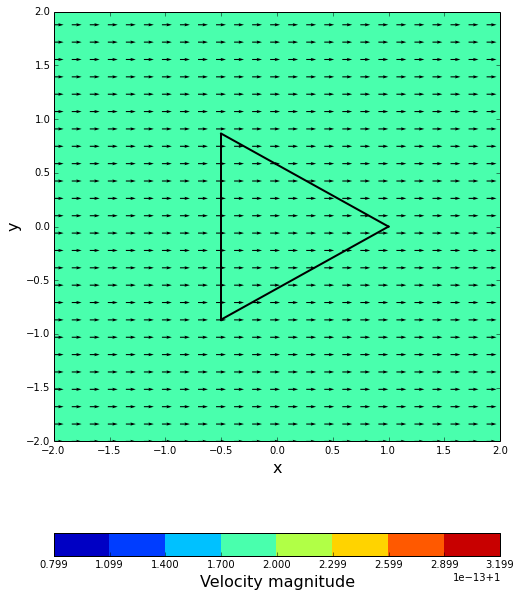

In [8]:
plot_flow(triangle)

##### Quiz 2

Why is the flow going through the body above?

1. We set `gamma=0` for the panels
1. We haven't applied the no-slip condition
1. We haven't determined the correct `gamma` for each panel

## System of linear equations

The no-slip boundary condition is

$$ u_s = \hat s\cdot\left[\vec U_\infty + \sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y)\right]=0 $$

We note again that this equation is **linear** in $\gamma$. 

So the goal is to set $\gamma$ on each sheet such that this condition is enforced on the body.

##### Quiz 3

How many unknowns are there?

1. $1$
1. $N$
1. $N^2$

But we only have one equation, the no-slip condition... right?

##### Numerical fundamental: Consistency
##### Develop enough equations to match the unknowns

For a linear system of equations to be consistent, that is for it to have a solution, we need as many equations as unknowns. 

Luckily the no-slip condition is a continuous equation - it applies to *every* point on the body. **Therefore, we can evaluate the boundary equation multiple times - say at the center of each panel**. Then we will have a consistent linear system.

---

There is one important point to consider before we do this: _the velocity a panel induces on itself_.

##### Quiz 4

What tangential velocity does a panel induce on the negative (body) side of itself?

1. $u_s =  \frac 12 \gamma$
1. $u_s = -\frac 12 \gamma$
1. $u_s = U_\infty$

(Hint: think about the previous notebook.)

Using this relation, the tangential velocity at the center of each panel is

$$ \frac 12 \gamma_i + \hat s_i \cdot \left[ \vec U_\infty + \sum_{j=0, j\ne i}^N \gamma_j \ \vec f_j(x_i,y_i)\right] = 0 \quad i=0\ldots N-1$$

where $\hat s_i$ is the tangent vector of panel $i$, and $x_i,y_i$ is the center of that panel. This information is given by the geometry, so the only unknowns are $\gamma_i$, the circulation at each panel. 

---
I've written a simple function to set-up this system of equations and solve it using numpy's  [`linalg` package](http://docs.scipy.org/doc/numpy/reference/routines.linalg.html). 

Let's import that function and use `help` to get the summary:

In [9]:
from VortexPanel import solve_gamma
help(solve_gamma)

Help on function solve_gamma in module VortexPanel:

solve_gamma(panels, alpha=0)
    # determine the vortex strength on a set of panels



We see that the function takes in an array of panels and an angle of attack, and determines the strength which satisfies the system of equations above.

Let's test it out!

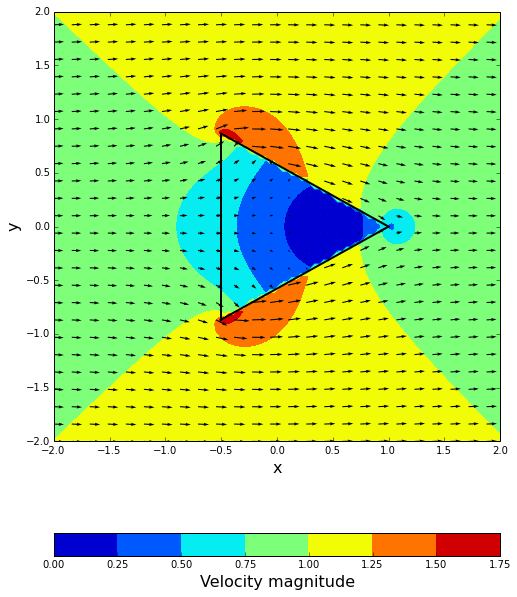

In [10]:
# define geometry
N_panels = 3
triangle = make_poly(N_panels,N_sides=3)    
solve_gamma(triangle)  # solve for gamma
plot_flow(triangle)    # compute flow field and plot

Much better! But...

##### Quiz 5

Why is there still flow through the wedge?

1. Modeling error       (ie incorrect conditions)
1. Numerical error      (ie insufficient resolution)
1. Implementation error (ie inadequate care)

(Hint: one of these is immediately testable.)

##### Numerical Fundamental: Convergence with resolution
##### The more panels you use, the closer you should get to the analytic solution

## Other shapes

We can now get the flow around **any** shape! Let try a circle. We follow the same pattern as we did with the triangle - defining the end points and then adding each panel to the array. 

In [11]:
def make_circle(N, xcen=0, ycen=0):
    # define the end-points of the panels for a unit circle
    theta = numpy.linspace(0, -2*numpy.pi, N+1)
    x_ends = xcen+numpy.cos(theta)
    y_ends = ycen+numpy.sin(theta)
    
    # define the panels
    circle = numpy.empty(N, dtype=object)
    for i in range(N):
        circle[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return circle

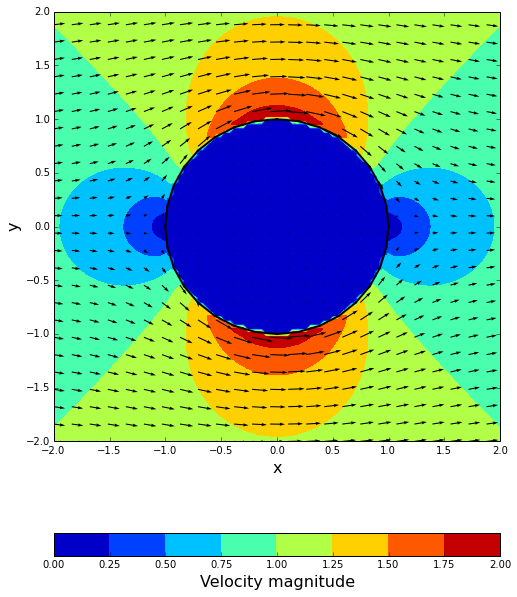

In [12]:
# defining the end-points of the panels
N = 32
circle = make_circle(N)     # make the shape
gamma = solve_gamma(circle) # solve for gamma
plot_flow(circle)           # compute flow field and plot

Looks about right!

Note that this function takes optional arguments to set the $x,y$ location of the center of the circle. Try them out...


##### Quiz 6

This vortex panel method can be used to solve for the flow around:

1. an ellipse
1. a pair of tandem bodies
1. a rudder

---
##### Your turn #2

 - ** Modify ** the `make_circle` function above to generate an ellipse instead of a circle when supplied with an aspect ratio `t_c`=$t/c$.
 - ** Create ** a 2:1 ellipse geometry shifted to be centered at $x=2,y=0$
 - ** Discuss ** whether the maximum speed around the ellipse is greater or less than that around the circle.
 - ** Combine ** the triangle and ellipse geometry together into one set of panels using `numpy.concatenate((body_1,body_2))` and solve for the flow.
 - ** Discuss ** if there is a *wake* between the bodies. Why or why not?

 
##### Solution #2

In [13]:
#ellipse = make_circle(N,t_c=0.5,xcen=2)    # make the shape
#solve_gamma(ellipse)                       # solve for gamma
#plot_flow(ellipse,xmax=5)                  # compute flow field and plot

In [14]:
# pair = ?   your code here... 